In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


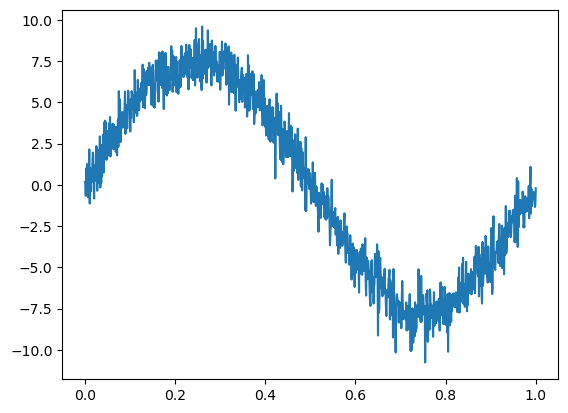

torch.Size([1024, 1])


In [25]:
from gaps.datamodules import SinusoidDataset
import matplotlib.pyplot as plt
import numpy as np

dataset = SinusoidDataset(10)
p, s = dataset[0]
plt.plot(dataset.times, s)
plt.show()
print(s.shape)

In [35]:
import torch
import torch.nn as nn
from networks.utils import MLP


class Generator(nn.Module):
    def __init__(
        self, input_lenght, input_channels, params_size, encoded_size=32, latent_size=8
    ):
        super().__init__()
        self.encoded_size = encoded_size
        self.latent_size = latent_size

        self.mlp = MLP(input_lenght * input_channels, self.encoded_size, num_layers=2)
        self.out_proj = MLP(self.latent_size + self.encoded_size, params_size)

    def forward(self, x):
        x = x.flatten(1)
        x = self.mlp(x.flatten(1))
        z = torch.randn(x.size(0), self.latent_size, device=x.device)
        x = torch.cat([x, z], dim=-1)
        x = self.out_proj(x)
        return x


class Critic(nn.Module):
    def __init__(self, input_lenght, input_channels, params_size, encoded_size=32):
        super().__init__()
        self.encoded_size = encoded_size
        self.mlp = MLP(input_lenght * input_channels, self.encoded_size, num_layers=2)
        self.out_proj = MLP(self.params_size + self.encoded_size, 1)

    def forward(self, x, params):
        x = x.flatten(1)
        x = self.mlp(x.flatten(1))
        x = torch.cat([x, params], dim=-1)
        x = self.out_proj(x)
        return x


model = Generator(1024, 1, 1)
a = model(torch.randn(4, 1024, 1))
print(a.shape)
# model = Critic(shape=(1, 28, 28), classes=10)
# a = model(torch.randint(0, 10, (1,)), a)
# print(a.shape)

torch.Size([4, 1024])
torch.Size([4, 32])
torch.Size([4, 8])
torch.Size([4, 40])
torch.Size([4, 1])


In [7]:
model = Generator(shape=(1, 28, 28), classes=10)
a = model(torch.randint(0, 10, (1,)))
print(a.shape)
model = Critic(shape=(1, 28, 28), classes=10)
a = model(torch.randint(0, 10, (1,)), a)
print(a.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1])


In [6]:
x = model(b)
# imshow x
import matplotlib.pyplot as plt
plt.imshow(x.detach().cpu().numpy()[0, 0])
print(x.shape)

model = Critic(shape=(1, 28, 28), classes=10)
print(model)
logit = model(b, x)
print(logit.shape)

NameError: name 'b' is not defined